<a href="https://colab.research.google.com/github/dellaanima/AIFFEL_QUEST/blob/master/QUEST03/QUEST03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quest 03

평가 기준

- 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
- 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
- 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 정상적인 이미지에 대한 고양이 스티커 적용

**남철 퍼실님께서 얼굴 이미지를 기부해주셨습니다.**

## 이미지 불러오기 및 시각화

* matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용.
* opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용. 그래서, 보정처리를 해주어야 한다.

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from PIL import Image

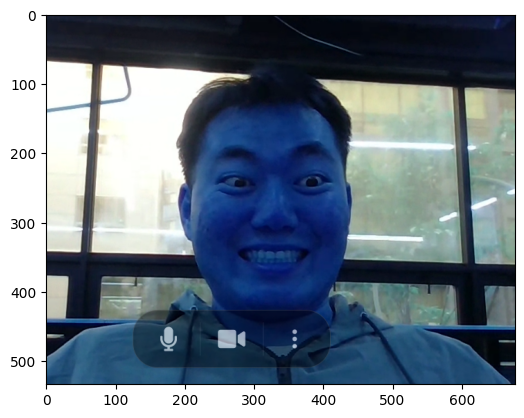

In [7]:
image_path = '/content/drive/MyDrive/Aiffel/Data/Quest03/face.png'
img_bgr = cv2.imread(image_path)    # OpenCV로 이미지를 불러옵니다
plt.imshow(img_bgr)
plt.show()

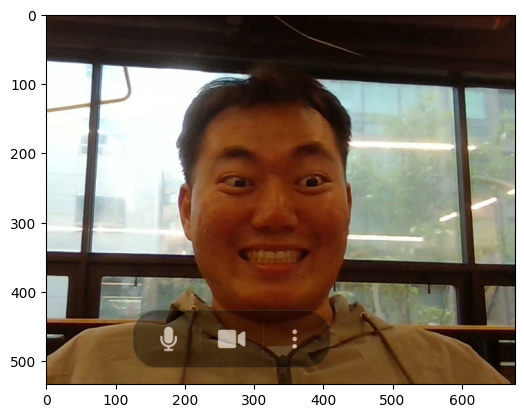

In [8]:
# plt.imshow 이전에 RGB 이미지로 바꾸어 줘야 함. cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 convert
plt.imshow(img_rgb)
plt.show()

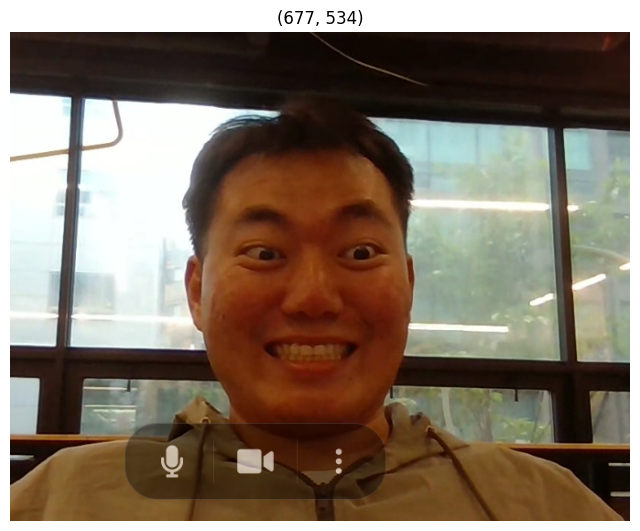

In [9]:
# PIL는 바로 RGB형식으로 가져옴
image = Image.open(image_path)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title(image.size)
plt.axis('off')
plt.show()

## 얼굴 검출 face detection
* dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾을 수 있다.

원본 이미지 형식 :  <class 'PIL.PngImagePlugin.PngImageFile'>
변환 이미지 형식 :  <class 'numpy.ndarray'>
rectangles[[(216, 167) (439, 390)]]


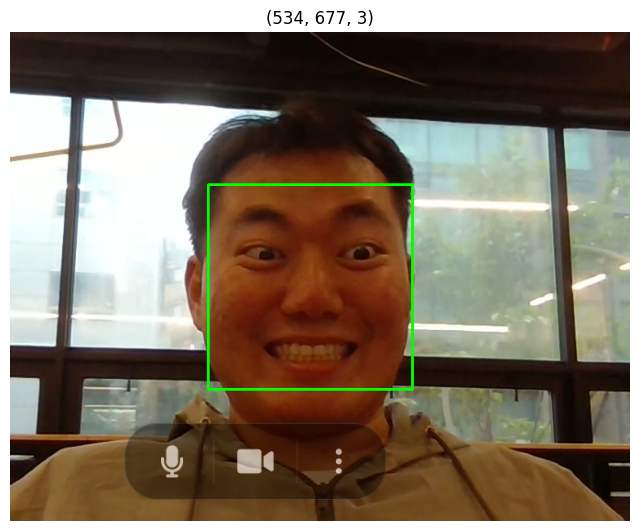

In [10]:
print('원본 이미지 형식 : ', type(image))
image = np.array(image)
print('변환 이미지 형식 : ', type(image))
image_show = image.copy() # 원본 이미지 image_show 이름으로 저장

detector_hog = dlib.get_frontal_face_detector() # Face detector, Returns the default face detector
face_detection = detector_hog(image_show, 1)         # detect input img, para 1 means 1 times upsamle

print(face_detection) # dlib detector 탐지 결과

# detected 얼굴 시각화
for rect in face_detection:
    left = rect.left()      # left x value
    top = rect.top()        # top y value
    right = rect.right()    # right x value
    bottom = rect.bottom()  # detect box bottom y value

    # add detect box in image
    cv2.rectangle(image_show, (left, top), (right, bottom), (0,255,0), 2) # 상자 그리기 Face Detection

plt.figure(figsize=(8,8))
plt.imshow(image_show)
plt.title(image_show.shape)
plt.axis('off')
plt.show()

## 얼굴 랜드마크 face landmark
* 이목구비의 위치를 추론하는 것을 face landmark localization 기술이용
* face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용.
* 원본이미지에 68개의 이목구비를 찾고 인덱스도 붙여본다.
* 고양이 스티커를 붙인다고 할때 코에 대해 중심을 잡아야 한다.(즉 29 ~ 35번)

In [4]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2023-07-13 02:21:34--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  69.1MB/s    in 0.9s    

2023-07-13 02:21:35 (69.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



68


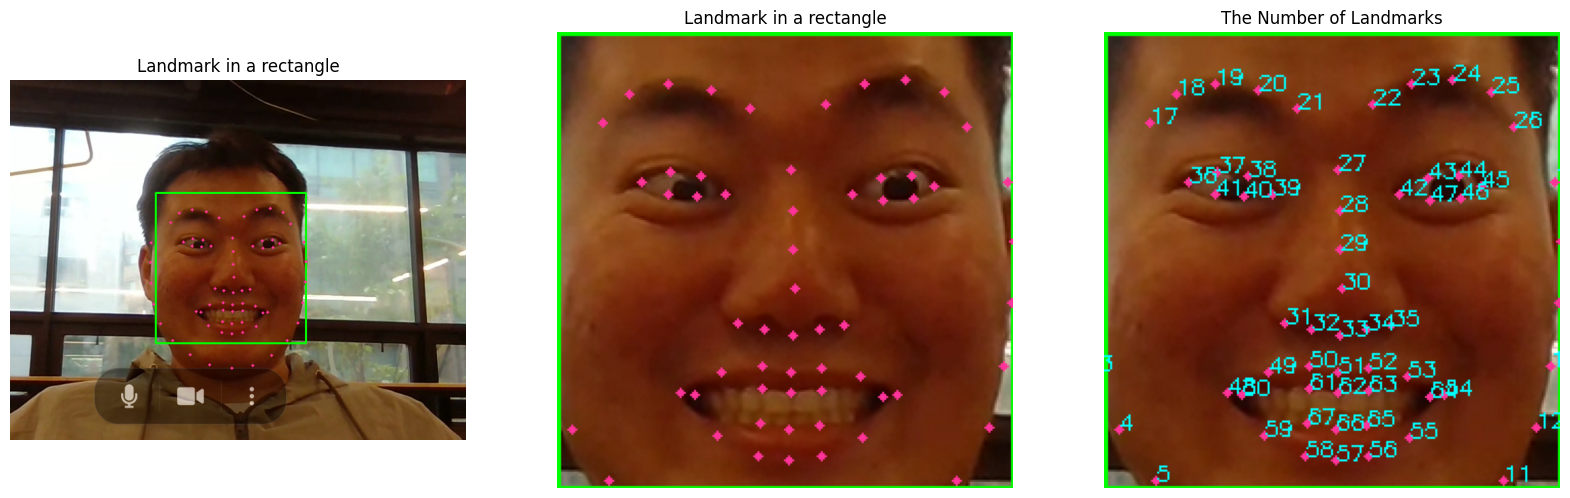

In [11]:
model_path = datFile
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for landmark in face_detection:
    points = landmark_predictor(image, landmark)

    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 68 landmark count

# landmark 출력
for landmark in list_landmarks:
    for index, point in enumerate(landmark):
        cv2.circle(image_show, point, 2, (255, 51, 153), -1)

plt.figure(figsize=(20,18))
plt.subplot(1,3,1)
plt.imshow(image_show)
plt.title('Landmark in a rectangle')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_show[top:top+(bottom-top),left:left+(right-left)])
plt.title('Landmark in a rectangle')
plt.axis('off')

image_show_text = image_show.copy()
# landmark에 index 추가
for landmark in list_landmarks:
    for index, point in enumerate(landmark):
        cv2.putText(image_show_text, str(index), point, fontScale=0.35, color=(0, 255, 255), fontFace = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX)

plt.subplot(1,3,3)
plt.imshow(image_show_text[top:top+(bottom-top),left:left+(right-left)])
plt.title('The Number of Landmarks')
plt.axis('off')

plt.show()

## 스티커 가져오기
* 고양이 수염 스티커의 파일주소를 sticker_path 에 저장하고 스티커 사진을 불러온다.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


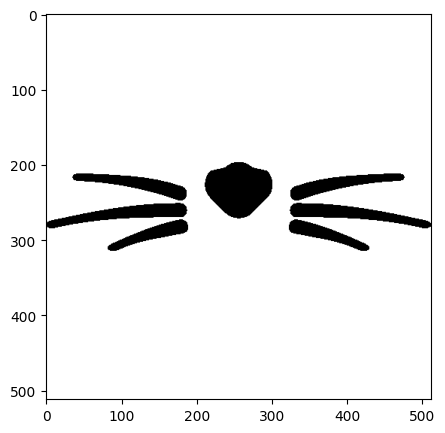

In [12]:
sticker_path = '/content/drive/MyDrive/Aiffel/Data/Quest03/cat-whiskers.png'
sticker = Image.open(sticker_path).convert('RGB')

plt.figure(figsize=(12, 5))
plt.imshow(sticker)
plt.show()

## 특징점별 좌표값 확인 및 스티커 적용

face_detection의 사각형의 좌표값 :

    left : 216
    top : 167
    right : 439
    bottom : 390

face_detection의 사각형의 너비, 높이 :

    w : 224
    h : 224

스티커 적용을 위한 좌표값 :

    x : 331 (landmark x point 30 and 33)
    y : 303 (landmark y point 30 and 33)
    refined_x : 219 = x - w // 2 (값이 코 위치이므로 스티커의 시작점을 조정)
    refined_y : 191 = y - h // 2 (값이 코 위치이므로 스티커의 시작점을 조정)

스티커의 shape

    img_sticker 변환전 shape : 512, 512, 3
    img_sticker 변환후 shape : 224, 224, 3


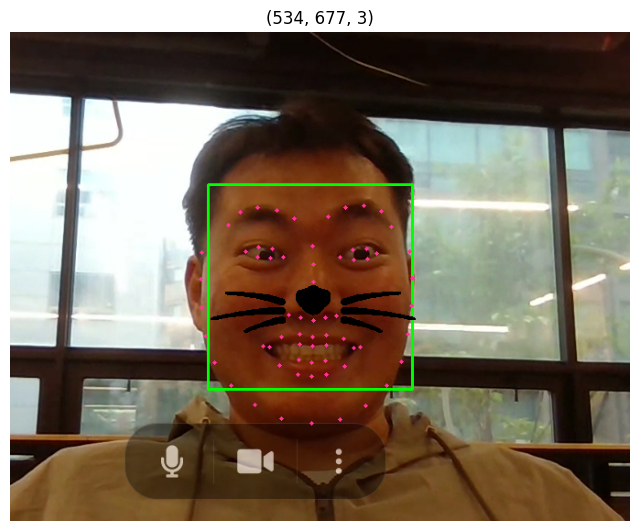

In [13]:
for face_rect, landmark in zip(face_detection, list_landmarks):

    x = (landmark[30][0] + landmark[33][0]) // 2
    y = (landmark[30][1] + landmark[33][1]) // 2

    w = face_rect.width()
    h = face_rect.height()

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = x - w // 2    # left
refined_y = y - h // 2    # top

sticker_area = image_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
image_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.imshow(image_show)
plt.title(image_show.shape)
plt.axis('off')
plt.show()

값들 확인용 코드

In [14]:
for rect in face_detection:
    left = rect.left()      # left x value
    top = rect.top()        # top y value
    right = rect.right()    # right x value
    bottom = rect.bottom()  # detect box bottom y value
    width = rect.width()
    height = rect.height()
print(left, top, right, bottom)
print (width, height)

for face_rect, landmark in zip(face_detection, list_landmarks):

    x = (landmark[30][0] + landmark[33][0]) // 2
    y = (landmark[30][1] + landmark[33][1]) // 2

print(x,y)

refined_x = x - w // 2    # left
refined_y = y - h // 2    # top

print(refined_x, refined_y)
img_sticker.shape

216 167 439 390
224 224
331 303
219 191


(224, 224, 3)

## 스티커 최종 적용

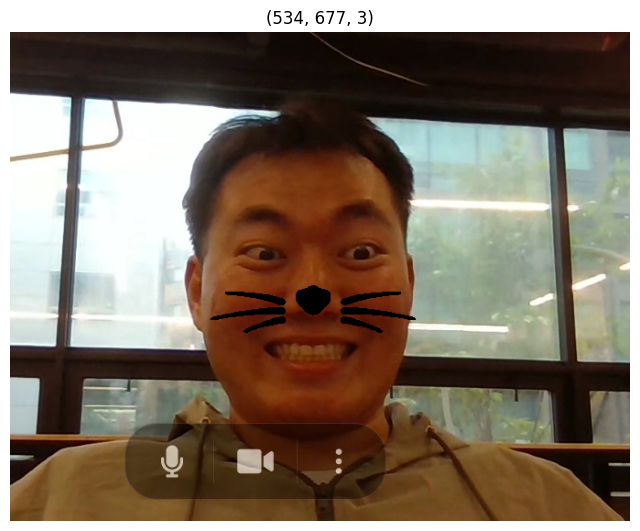

In [15]:
sticker_area = image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title(image.shape)
plt.axis('off')
plt.show()

# 2. 변형이 있는 이미지에 대한 스티커 적용

## 2.1 얼굴의 각도가 정면이 아닌 케이스


- 얼굴의 각도가 정면이 아닌 케이스에서 face detection 은 정상적으로 탐지
- landmark 정상적으로 찍히지만, 스티커에 원근감이 존재하지 않아서, 부자연스럽게 스티커가 적용 됨.

- 따라서 이러한 문제를 해결하기 위하여, 스티커를 변형하는 함수 설계
-코와 얼굴 윤곽을 기준으로 스티커 변형

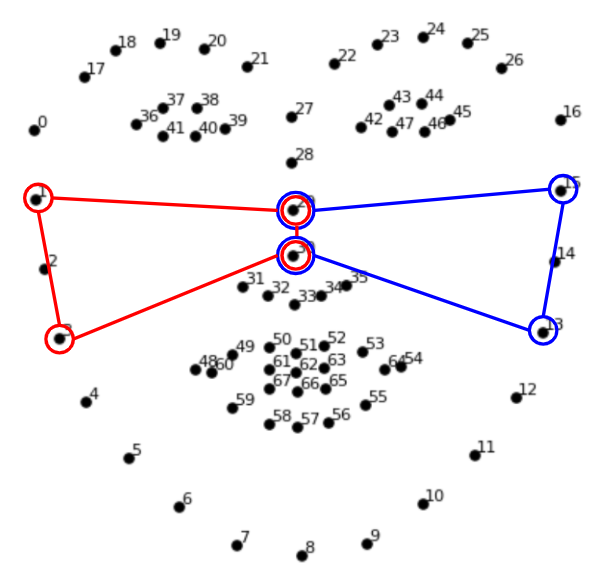

### 스티커 변형 위치 파악

In [16]:
def sticker_transformation_test(image):
    image_show = image.copy()   # 원본 이미지 image_show 이름으로 저장
    detector_hog = dlib.get_frontal_face_detector() # Face detector, Returns the default face detector
    dlib_rects = detector_hog(image, 1)             # detect input img, para 1 means 1 times upsamle

    # detected 얼굴 시각화
    for rect in dlib_rects:
        left = rect.left()      # left x value
        top = rect.top()        # top y value
        right = rect.right()    # right x value
        bottom = rect.bottom()  # detect box bottom y value

        # add detect box in image
        cv2.rectangle(image_show, (left, top), (right, bottom), (0,255,0), 2) # 상자 그리기 Face Detection

    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냄.
    for dlib_rect in dlib_rects:
        landmark_predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
        points = landmark_predictor(image_show, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # face landmark 좌표를 저장
        list_landmarks.append(list_points)  # total 68 landmark count

    # landmark 출력
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(image_show, point, 2, (0, 128, 255), -1)

    # 고양이 스티커의 영역(꼭지점으로 연결)
    vertices1 = np.array([landmark[1], landmark[29], landmark[33], landmark[3]])
    vertices2 = np.array([landmark[29], landmark[15], landmark[13], landmark[33]])
    cv2.polylines(image_show, [vertices1], isClosed=True, color=(0, 128, 255))
    cv2.polylines(image_show, [vertices2], isClosed=True, color=(0, 128, 255))

    plt.imshow(cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB))
    plt.show()

- image source : https://www.pinterest.co.kr/pin/823806956857179567/

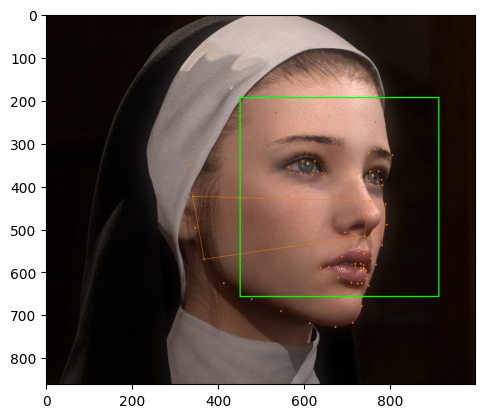

In [ ]:
image_test = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/side_face.png')
sticker_transformation_test(image_test)

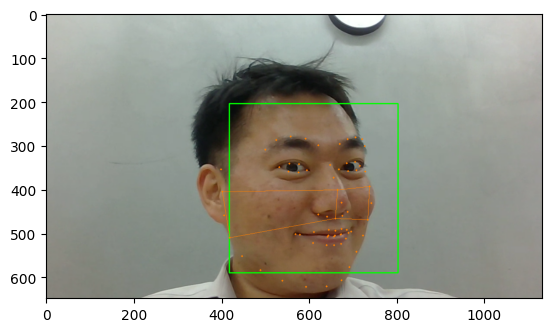

In [17]:
image_test = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/side_face_2.png')
sticker_transformation_test(image_test)

### 스티커 변형 후 적용
* 고양이 수염 스티커를 얼굴 절반 기준으로 왼쪽, 오른쪽 나누어 변형
* 고양이 스티커 이미지를 얼굴 면적을 기준으로 이미지의 형태를 변환(Perspective Transform)
* 최종 출력



고양이 스티커를 다음과 같이 변형한다.

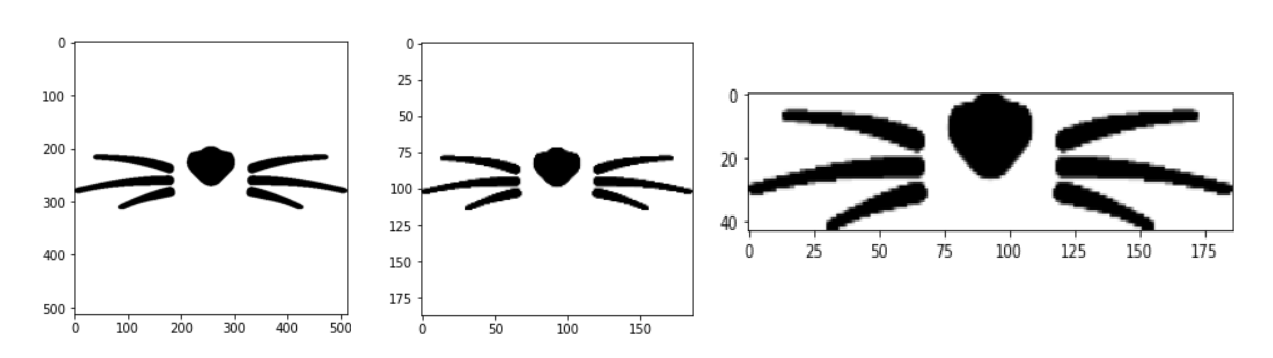

In [19]:
# sticker image points transform
def points_box(points):
    x_zero = np.min([x for x, _y in points])
    y_zero = np.min([y for _x, y in points])
    points_new = []
    for pnt in points:
        points_new.append([pnt[0] - x_zero, pnt[1] - y_zero])
    return points_new

# sticker image transform
def transform_image_sticker(image_sticker, landmark):
    sticker_gray = cv2.cvtColor(image_sticker, cv2.COLOR_BGR2GRAY)  # sticker를 GRAY Scale로 변환
    img_rev = cv2.bitwise_not(sticker_gray)     # sticker에 bitwise_not연산(ex. 0->1, 1->0)
    coords = cv2.findNonZero(img_rev)
    x_dummy, y, w_dummy, h = cv2.boundingRect(coords)

    image_sticker = image_sticker[y : y + h, :, :]  # sticker 영역 수정

    sticker_half = image_sticker.shape[1] // 2      # sticker의 절반
    sticker_left = image_sticker[:, :sticker_half]  # sticker 절반 기준 왼쪽
    sticker_right = image_sticker[:, sticker_half:] # sticker 절반 기준 오른쪽

    h, w = image_sticker.shape[0], image_sticker.shape[1] # 변환된 스티거의 높이, 너비

    # 얼굴형태에 맞게 변환
    points = [[0, 0], [0, h], [w // 2, 0], [w // 2, h]]
    v1_src = np.float32(points)
    v2_src = np.float32(points)
    v1 = np.array([landmark[1], landmark[3], landmark[29], landmark[33]])   # 얼굴기준 왼쪽 landmark
    v2 = np.array([landmark[29], landmark[33], landmark[15], landmark[13]]) # 얼굴기준 오른쪽 landmark
    v1_dst = np.float32(points_box(v1))
    v2_dst = np.float32(points_box(v2))

    # cv2.getPerspectiveTransform()
    # cv2.warpPerspective() 함수에 변환행렬값을 적용하여 최종 결과 이미지를 얻을 수 있음
    m1 = cv2.getPerspectiveTransform(v1_src, v1_dst)
    m2 = cv2.getPerspectiveTransform(v2_src, v2_dst)

    x1, y1, w1, h1 = cv2.boundingRect(v1)
    x2, y2, w2, h2 = cv2.boundingRect(v2)
    sticker_left_warp = cv2.warpPerspective(sticker_left, m1, (w1, h1), borderValue=(255, 255, 255))
    sticker_right_warp = cv2.warpPerspective(sticker_right, m2, (w2, h2), borderValue=(255, 255, 255))

    return (x1, y1, sticker_left_warp), (x2, y2, sticker_right_warp)

# 이미지가 벗어난다면...
def refined_image(image, x, y, w, h):
    refined_x = x - w // 2
    refined_y = y - h
    if refined_x < 0:
        image = image[:, -refined_x:]
    if refined_y < 0:
        image = image[-refined_y:, :]
    return image

# sticker attach
def sticker(image, image_sticker):
    image_show = image.copy()   # 원본 이미지 image_show 이름으로 저장
    detector_hog = dlib.get_frontal_face_detector() # Face detector, Returns the default face detector
    dlib_rects = detector_hog(image, 1)             # detect input img, para 1 means 1 times upsamle

    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냄.
    for dlib_rect in dlib_rects:
        landmark_predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
        points = landmark_predictor(image_show, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # face landmark 좌표를 저장
        list_landmarks.append(list_points)  # total 68 landmark count

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        w = dlib_rect.width()
        h = dlib_rect.height()
        x = landmark[30][0] # landmark의 30은 코의 위치
        y = landmark[30][1] + h // 2

        image_sticker = cv2.resize(image_sticker, (w, h))         # sticker 영역 box 크기만큼 resize
        image_sticker = refined_image(image_sticker, x, y, w, h)  # 만약 이미지가 벗어나면 재정의
        p1, p2 = transform_image_sticker(image_sticker, landmark) # sticker 변경

        for x, y, sticker in [p1, p2]:
            sticker_area = image_show[y : y + sticker.shape[0], x : x + sticker.shape[1]]
            image_show[y : y + sticker.shape[0], x : x + sticker.shape[1]] = np.where(sticker >= 128, sticker_area, sticker)

    return image_show

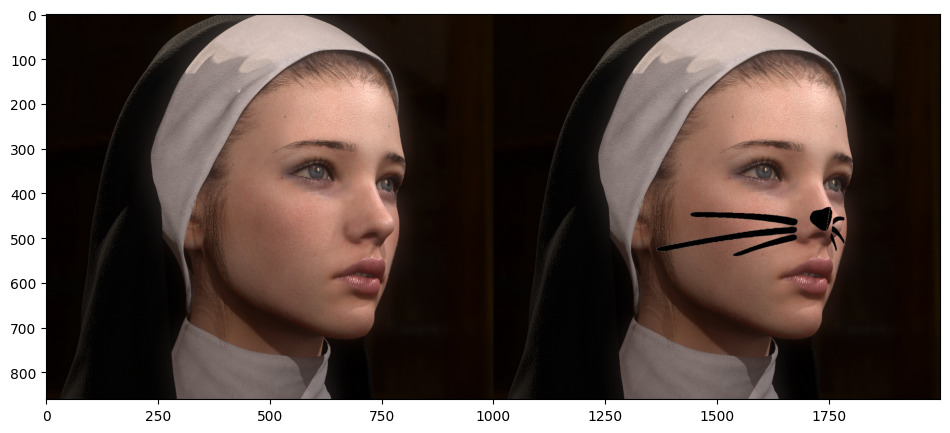

In [21]:
img_sticker = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/cat-whiskers.png')
image = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/side_face.png')
image_transform = sticker(image, img_sticker)
result = cv2.hconcat([image, image_transform])
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

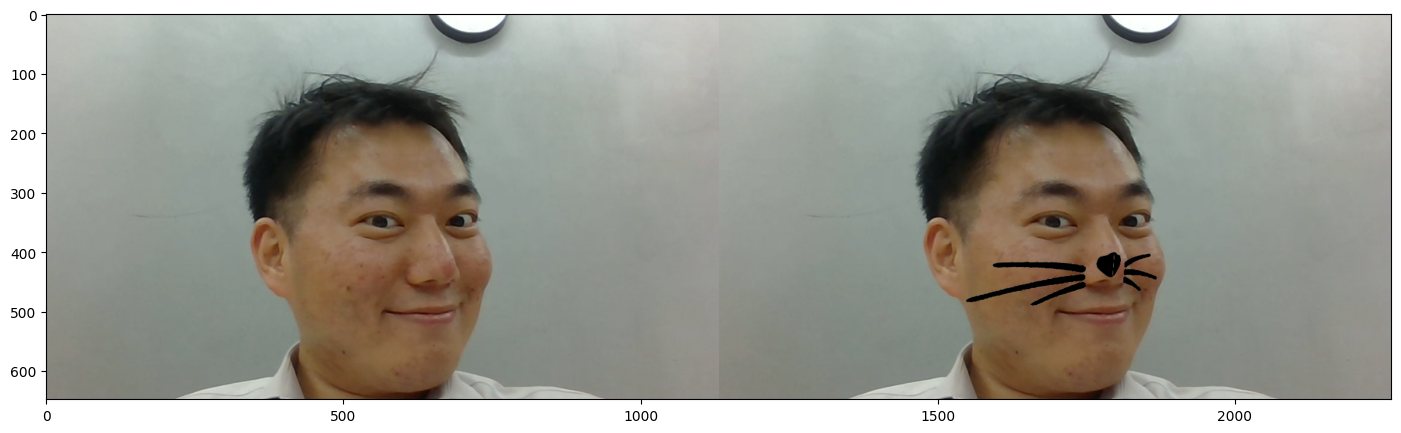

In [ ]:
img_sticker = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/cat-whiskers.png')
image = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/side_face_2.png')
image_transform = sticker(image, img_sticker)
result = cv2.hconcat([image, image_transform])
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

## 2.2 밝기가 어두운 얼굴 케이스
* 그림자가 있는 얼굴 사진에 대해서 적용해봤다.
- image Source : https://www.pinterest.co.kr/pin/512777107697404305/

### 어두운 사진에 대한 face detection 및 landmark 적용

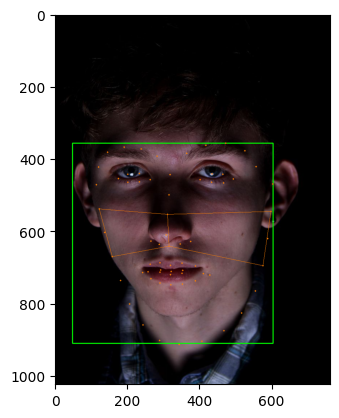

In [ ]:
image_test = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/dark_face.png')
sticker_transformation_test(image_test)

### 최종 출력 적용

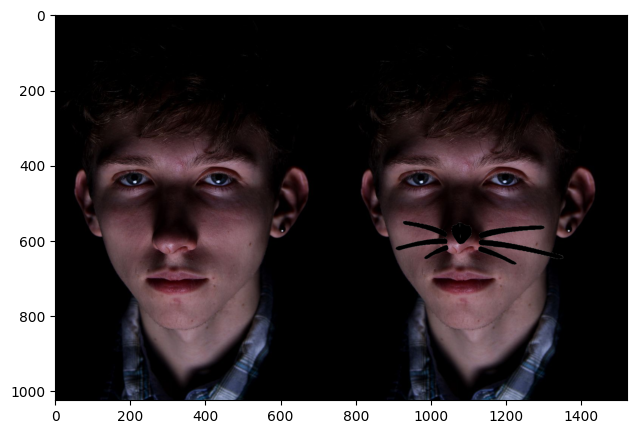

In [ ]:
img_sticker = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/cat-whiskers.png')
image = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/dark_face.png')
image_transform = sticker(image, img_sticker)
result = cv2.hconcat([image, image_transform])
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

## 2.3 거리가 있는 사진
*  서있는 사람 이미지로 적용해봤다.
- image source : https://www.pinterest.co.kr/pin/614389574185618396/

### 거리가 있는 사진에 대한 face detection 및 landmark 적용

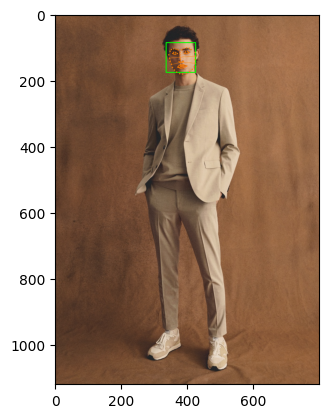

In [ ]:
image_test = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/far_face.png')
sticker_transformation_test(image_test)

### 최종 출력 적용

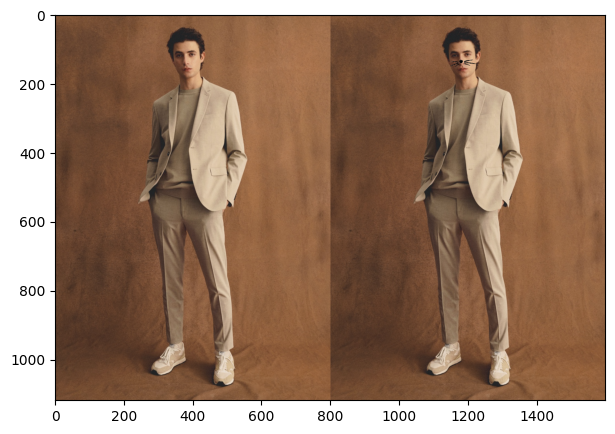

In [ ]:
img_sticker = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/cat-whiskers.png')
image = cv2.imread('/content/drive/MyDrive/Aiffel/Data/Quest03/far_face.png')
image_transform = sticker(image, img_sticker)
result = cv2.hconcat([image, image_transform])
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 분석 결론
* 정면사진은 face detection, landmark, 스티커 적용 전부 정상적으로 적용 가능
* 정면이 아닌 사진 : face detection, landmark, 전부 제대로 인식 가능하지만, 스티커 적용을 위해서, 스티커의 크기 위치를 조정하는 작업 필요함.
* 밝기가 어두운 사진 : face detection, landmark, 스티커 적용 전부 정상적으로 적용 가능
* 거리가 있는 사진 : face detection, landmark, 스티커 적용 전부 정상적으로 적용 가능

